# 正規分布モデルの共役事前分布によるベイズ統計

* 黒木玄
* 2022-09-03～2022-09-06
$
\newcommand\ds{\displaystyle}
\newcommand\op[1]{{\operatorname{#1}}}
\newcommand\R{{\mathbb R}}
\newcommand\var{\op{var}}
\newcommand\cov{\op{cov}}
\newcommand\ybar{{\bar y}}
\newcommand\sigmahat{{\hat\sigma}}
$

<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#正規分布モデルの共役事前分布とその応用" data-toc-modified-id="正規分布モデルの共役事前分布とその応用-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>正規分布モデルの共役事前分布とその応用</a></span><ul class="toc-item"><li><span><a href="#逆ガンマ正規分布" data-toc-modified-id="逆ガンマ正規分布-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>逆ガンマ正規分布</a></span></li><li><span><a href="#共役事前分布のBayes更新" data-toc-modified-id="共役事前分布のBayes更新-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>共役事前分布のBayes更新</a></span></li><li><span><a href="#μの周辺事前・事後分布および事前・事後予測分布" data-toc-modified-id="μの周辺事前・事後分布および事前・事後予測分布-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>μの周辺事前・事後分布および事前・事後予測分布</a></span></li><li><span><a href="#Jeffreys事前分布の場合" data-toc-modified-id="Jeffreys事前分布の場合-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Jeffreys事前分布の場合</a></span></li><li><span><a href="#Jeffreys事前分布の場合の結果の数値的確認" data-toc-modified-id="Jeffreys事前分布の場合の結果の数値的確認-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Jeffreys事前分布の場合の結果の数値的確認</a></span></li><li><span><a href="#平均と対数分散について一様な事前分布の場合" data-toc-modified-id="平均と対数分散について一様な事前分布の場合-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>平均と対数分散について一様な事前分布の場合</a></span></li><li><span><a href="#平均と対数分散について一様な事前分布の場合の結果の数値的確認" data-toc-modified-id="平均と対数分散について一様な事前分布の場合の結果の数値的確認-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>平均と対数分散について一様な事前分布の場合の結果の数値的確認</a></span></li><li><span><a href="#通常の信頼区間と予測区間との比較" data-toc-modified-id="通常の信頼区間と予測区間との比較-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>通常の信頼区間と予測区間との比較</a></span></li><li><span><a href="#データの数値から事前分布を決めた場合" data-toc-modified-id="データの数値から事前分布を決めた場合-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>データの数値から事前分布を決めた場合</a></span></li><li><span><a href="#n-=-5-では適応事前分布の場合と無情報事前分布の場合の結果が結構違う." data-toc-modified-id="n-=-5-では適応事前分布の場合と無情報事前分布の場合の結果が結構違う.-1.10"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>n = 5 では適応事前分布の場合と無情報事前分布の場合の結果が結構違う.</a></span></li><li><span><a href="#n-=-20-ではデフォルト事前分布の場合と無情報事前分布の場合の結果が近付く." data-toc-modified-id="n-=-20-ではデフォルト事前分布の場合と無情報事前分布の場合の結果が近付く.-1.11"><span class="toc-item-num">1.11&nbsp;&nbsp;</span>n = 20 ではデフォルト事前分布の場合と無情報事前分布の場合の結果が近付く.</a></span></li><li><span><a href="#n-=-20-で事前分布とデータの数値の相性が悪い場合" data-toc-modified-id="n-=-20-で事前分布とデータの数値の相性が悪い場合-1.12"><span class="toc-item-num">1.12&nbsp;&nbsp;</span>n = 20 で事前分布とデータの数値の相性が悪い場合</a></span></li></ul></li></ul></div>

In [1]:
using Distributions
using LinearAlgebra
using Random
using StatsPlots
default(fmt=:png, size=(500, 350),
    titlefontsize=10, tickfontsize=6, guidefontsize=9,
    plot_titlefontsize=10)
using SymPy
using Turing

In [2]:
# Override the Base.show definition of SymPy.jl:
# https://github.com/JuliaPy/SymPy.jl/blob/29c5bfd1d10ac53014fa7fef468bc8deccadc2fc/src/types.jl#L87-L105

@eval SymPy function Base.show(io::IO, ::MIME"text/latex", x::SymbolicObject)
    print(io, as_markdown("\\displaystyle " *
            sympy.latex(x, mode="plain", fold_short_frac=false)))
end
@eval SymPy function Base.show(io::IO, ::MIME"text/latex", x::AbstractArray{Sym})
    function toeqnarray(x::Vector{Sym})
        a = join(["\\displaystyle " *
                sympy.latex(x[i]) for i in 1:length(x)], "\\\\")
        """\\left[ \\begin{array}{r}$a\\end{array} \\right]"""
    end
    function toeqnarray(x::AbstractArray{Sym,2})
        sz = size(x)
        a = join([join("\\displaystyle " .* map(sympy.latex, x[i,:]), "&")
                for i in 1:sz[1]], "\\\\")
        "\\left[ \\begin{array}{" * repeat("r",sz[2]) * "}" * a * "\\end{array}\\right]"
    end
    print(io, as_markdown(toeqnarray(x)))
end

In [3]:
# One sample t-test

function pvalue_ttest(x̄, s², n, μ)
    t = (x̄ - μ)/√(s²/n)
    2ccdf(TDist(n-1), abs(t))
end

function pvalue_ttest(x, μ)
    x̄, s², n = mean(x), var(x), length(x)
    pvalue_ttest(x̄, s², n, μ)
end

function confint_ttest(x̄, s², n; α = 0.05)
    c = quantile(TDist(n-1), 1-α/2)
    [x̄ - c*√(s²/n), x̄ + c*√(s²/n)]
end

function confint_ttest(x; α = 0.05)
    x̄, s², n = mean(x), var(x), length(x)
    confint_ttest(x̄, s², n; α)
end

confint_ttest (generic function with 2 methods)

In [4]:
# Bayesian analogue of one sample t-test

posterior_μ_ttest(n, x̄, s²) = x̄ + √(s²/n)*TDist(n-1)
posterior_μ_ttest(x) = posterior_μ_ttest(length(x), mean(x), var(x))

preddist_ttest(n, x̄, s²) = x̄ + √(s²*(1 + 1/n))*TDist(n-1)
preddist_ttest(x) = preddist_ttest(length(x), mean(x), var(x))

preddist_ttest (generic function with 2 methods)

In [5]:
# Jeffreys事前分布などのimproper事前分布を定義するために以下が使われる.

"""
    PowerPos(p::Real)

The *positive power distribution* with real-valued parameter `p` is the improper distribution
of real numbers that has the improper probability density function

```math
f(x) = \\begin{cases}
0 & \\text{if } x \\leq 0, \\\\
x^p & \\text{otherwise}.
\\end{cases}
```
"""
struct PowerPos{T<:Real} <: ContinuousUnivariateDistribution
    p::T
end
PowerPos(p::Integer) = PowerPos(float(p))

Base.minimum(d::PowerPos{T}) where T = zero(T)
Base.maximum(d::PowerPos{T}) where T = T(Inf)

Base.rand(rng::Random.AbstractRNG, d::PowerPos) = rand(rng) + 0.5
function Distributions.logpdf(d::PowerPos, x::Real)
    T = float(eltype(x))
    return x ≤ 0 ? T(-Inf) : d.p*log(x)
end

Distributions.pdf(d::PowerPos, x::Real) = exp(logpdf(d, x))

# For vec support
function Distributions.loglikelihood(d::PowerPos, x::AbstractVector{<:Real})
    T = float(eltype(x))
    return any(xi ≤ 0 for xi in x) ? T(-Inf) : d.p*log(prod(x))
end

@doc PowerPos

```
PowerPos(p::Real)
```

The *positive power distribution* with real-valued parameter `p` is the improper distribution of real numbers that has the improper probability density function

$$
f(x) = \begin{cases}
0 & \text{if } x \leq 0, \\
x^p & \text{otherwise}.
\end{cases}
$$


In [6]:
# 以下は使わないが,
# Flat() や PowerPos(p) と正規分布や逆ガンマ分布の関係は次のようになっている.

MyNormal(μ, σ) = σ == Inf ? Flat() : Normal(μ, σ)
MyInverseGamma(κ, θ) = θ == 0 ? PowerPos(-κ-1) : InverseGamma(κ, θ)

MyInverseGamma (generic function with 1 method)

## 正規分布モデルの共役事前分布とその応用

### 逆ガンマ正規分布

平均 $\mu\in\R$, 分散 $v=\sigma^2\in\R_{>0}$ の正規分布の確率密度函数を次のように表す:

$$
p_\op{Normal}(y|\mu, v) =
\frac{1}{\sqrt{2\pi v}}\exp\left(-\frac{1}{2v}(y-\mu)^2\right)
\quad (y\in \R).
$$

分散パラメータ $\sigma^2$ を $v$ に書き直している理由は, $\sigma^2$ を1つの変数として扱いたいからである.

パラメータ $\kappa, \theta > 0$ の逆ガンマ分布の確率密度函数を次のように書くことにする:

$$
p_\op{InverseGamma}(v|\kappa,\theta) =
\frac{\theta^\kappa}{\Gamma(\kappa)}
v^{-\kappa-1}\exp\left(-\frac{\theta}{v}\right)
\quad (v > 0).
$$

$v$ がこの逆ガンマ分布に従う確率変数だとすると, 

$$
\begin{aligned}
&
\frac{1}{v} \sim
\op{Gamma}\left(\kappa,\, \frac{1}{\theta}\right) =
\frac{1}{2\theta}\op{Gamma}\left(\frac{2\kappa}{2},\, 2\right) =
\frac{1}{2\theta}\op{Chisq}(2\kappa),
\\ &
E[v] = \frac{\theta}{\kappa - 1}, \quad
\var(v) = \frac{E[v]^2}{\kappa - 2}.
\end{aligned}
$$

$A$ と $B$ が $\mu, v$ に関する定数因子の違いを除いて等しいことを $A\propto B$ と書くことにする.

逆ガンマ正規分布の密度函数を次のように定義する:

$$
\begin{aligned}
p_\op{InverseGammaNormal}(\mu,v|\mu_*, v_*, \kappa, \theta) &=
p_\op{Normal}(\mu|\mu_*, v_* v) p_\op{InverseGamma}(v|\kappa, \theta)
\\ &\propto
v^{-(\kappa+1/2)-1}
\exp\left(-\frac{1}{v}\left(\theta + \frac{1}{2v_*}(\mu-\mu_*)^2\right)\right).
\end{aligned}
$$

この逆ガンマ正規分布の密度函数に従う確率変数を $\mu,v$ と書くと,

$$
E[v] = \frac{\theta}{\kappa-1}, \quad
\var(v) = \frac{E[v]^2}{\kappa-2}, \quad
\cov(\mu, v) = 0, \quad
E[\mu] = \mu_*, \quad
\var(\mu) = v_* E[v].
$$

この逆ガンマ正規分布が正規分布の共役事前分布になっていることを次の節で確認する. 

### 共役事前分布のBayes更新

データの数値 $y_1,\ldots,y_n$ が与えられたとき, 正規分布モデルの尤度函数は

$$
\prod_{i=1}^n p_\op{Normal}(y_i|\mu,v) \propto
v^{-n/2}\exp\left(-\frac{1}{2v}\sum_{i=1}^n(y_i-\mu)^2\right)
$$

の形になる. このとき,

$$
\ybar = \frac{1}{n}\sum_{i=1}^n y_i, \quad
\sigmahat^2 = \frac{1}{n}\sum_{i=1}^n (y_i - \ybar)^2.
$$

とおくと, 

$$
\sum_{i=1}^n(y_i-\mu)^2 = n(\mu - \ybar)^2 + n\sigmahat^2
$$

なので, 尤度を最大化する $\mu, v$ は $\mu=\ybar$, $v=\sigmahat^2$ になることがわかる.

さらに, 次が成立することもわかる:

$$
\begin{aligned}
&
\prod_{i=1}^n p_\op{Normal}(y_i|\mu,v)\times
p_\op{InverseGammaNormal}(\mu,v|\mu_*, v_*, \kappa, \theta)
\\ &\propto
v^{-n/2}\exp\left(-\frac{n}{2v}\left((\mu-\ybar)^2 + \sigmahat^2\right)\right)\times
v^{-(\kappa+1/2)-1}
\exp\left(-\frac{1}{v}\left(\theta + \frac{1}{2v_*}(\mu-\mu_*)^2\right)\right)
\\ &=
v^{-(\kappa+n/2+1/2)-1}
\exp\left(-\frac{1}{v}\left(
\theta + \frac{n}{2}\left(\sigmahat^2 + \frac{(\ybar - \mu_*)^2}{1+nv_*}\right) +
\frac{1+nv_*}{2v_*}\left(\mu - \frac{\mu_*+nv_*\ybar}{1+nv_*}\right)^2
\right)\right).
\end{aligned}
$$

ゆえに共役事前分布から得られる事後分布のパラメータは次のようになる:

$$
\begin{alignedat}{2}
&
\tilde\kappa = \kappa + \frac{n}{2} =
\frac{n}{2}\left(1 + \frac{2\kappa}{n}\right), 
\\ &
\tilde\theta =
\theta + \frac{n}{2}\left(\sigmahat^2 + \frac{(\ybar - \mu_*)^2}{1+nv_*}\right) =
\frac{n\sigmahat^2}{2}\left(1 + \frac{2\theta}{n\sigmahat^2} + \frac{(\ybar - \mu_*)^2}{(1+nv_*)\sigmahat^2}\right),
\\ &
\tilde\mu_* = \frac{\mu_*+nv_*\ybar}{1+nv_*} =
\ybar\frac{1+\mu_*/(nv_*\ybar)}{1+1/(nv_*)}, 
\\ &
\tilde v_* = \frac{v_*}{1+nv_*} =
\frac{1}{n}\frac{1}{1+1/(nv_*)}.
\end{alignedat}
$$

In [7]:
function bayesian_update(μstar, vstar, κ, θ, n, ȳ, σ̂²)
    μstar_new = (μstar/vstar + n*ȳ)/(1/vstar + n)
    vstar_new = 1/(1/vstar + n)
    κ_new = κ + n/2
    θ_new = θ + (n/2)*(σ̂² + ((ȳ - μstar)^2/vstar)/(1/vstar + n))
    μstar_new, vstar_new, κ_new, θ_new
end

function bayesian_update(μstar, vstar, κ, θ, y)
    n, ȳ, σ̂² = length(y), mean(y), var(y; corrected=false)
    bayesian_update(μstar, vstar, κ, θ, n, ȳ, σ̂²)
end

bayesian_update (generic function with 2 methods)

In [8]:
@vars n ȳ v̂ μ v μ0 v0 κ θ

(n, ȳ, v̂, μ, v, μ0, v0, κ, θ)

In [9]:
negloglik = n/2*log(v) + n/(2v)*((μ - ȳ)^2 + v̂)

             /            2\
n*log(v)   n*\v̂ + (-ȳ + μ) /
-------- + -----------------
   2              2*v       

In [10]:
neglogpri = (κ + 1//2 + 1)*log(v) + 1/v*(θ + 1/(2v0)*(μ-μ0)^2)

                               2
                       (μ - μ0) 
                   θ + ---------
                          2*v0  
(κ + 3/2)*log(v) + -------------
                         v      

In [11]:
neglogpost = (κ + n/2 + 1//2 + 1)*log(v) +  1/v*(
    θ + n/2*(v̂ + 1/(1+n*v0)*(ȳ - μ0)^2) +
    (1 + n*v0)/(2v0)*(μ - (μ0 + n*v0*ȳ)/(1 + n*v0))^2)

                       /            2\                        2           
                       |    (ȳ - μ0) |       /    n*v0*ȳ + μ0\            
                     n*|v̂ + ---------|       |μ - -----------| *(n*v0 + 1)
                       \     n*v0 + 1/       \      n*v0 + 1 /            
                     ----------------- + θ + -----------------------------
/n       3\                  2                            2*v0            
|- + κ + -|*log(v) + -----------------------------------------------------
\2       2/                                    v                          

In [12]:
simplify(negloglik + neglogpri - neglogpost)

0

In [13]:
bayesian_update(μ0, v0, κ, θ, n, ȳ, v̂) |> collect

4-element Vector{Sym}:
                  (n*ȳ + μ0/v0)/(n + 1/v0)
                              1/(n + 1/v0)
                                   n/2 + κ
 n*(v̂ + (ȳ - μ0)^2/(v0*(n + 1/v0)))/2 + θ

### μの周辺事前・事後分布および事前・事後予測分布

確率密度函数

$$
p(\mu|\mu_*,v_*,\kappa,\theta) =
\int_{\R_{>0}} p_\op{InverseGammaNormal}(\mu,v|\mu_*,v_*,\kappa,\theta) \,dv
$$

で定義される$\mu$ の周辺事前分布は次になる:

$$
\mu \sim
\mu_* + \sqrt{\frac{\theta}{\kappa}v_*}\;\op{TDist}(2\kappa).
$$

確率密度函数

$$
p_*(y_\op{new}|\mu_*,v_*,\kappa,\theta) =
\iint_{\R\times\R_{>0}}
p_\op{Normal}(y_\op{new}|\mu,v)
p_\op{InverseGammaNormal}(\mu,v|\mu_*,v_*,\kappa,\theta)
\,d\mu\,dv
$$

で定義される $y_\op{new}$ の事前予測分布は次になる:

$$
y_\op{new} \sim
\mu_* + \sqrt{\frac{\theta}{\kappa}(1+v_*)}\;\op{TDist}(2\kappa).
$$

パラメータをBayes更新後のパラメータ

$$
\begin{alignedat}{2}
&
\tilde\kappa = \kappa + \frac{n}{2} =
\frac{n}{2}\left(1 + \frac{2\kappa}{n}\right), 
\\ &
\tilde\theta =
\theta + \frac{n}{2}\left(\sigmahat^2 + \frac{(\ybar - \mu_*)^2}{1+nv_*}\right) =
\frac{n\sigmahat^2}{2}\left(1 + \frac{2\theta}{n\sigmahat^2} + \frac{(\ybar - \mu_*)^2}{(1+nv_*)\sigmahat^2}\right),
\\ &
\tilde\mu_* = \frac{\mu_*+nv_*\ybar}{1+nv_*} =
\ybar\frac{1+\mu_*/(nv_*\ybar)}{1+1/(nv_*)}, 
\\ &
\tilde v_* = \frac{v_*}{1+nv_*} =
\frac{1}{n}\frac{1}{1+1/(nv_*)}.
\end{alignedat}
$$

に置き換えればこれは $\mu$ の周辺事後分布および事後予測分布になる.

その事後分布を使った区間推定の幅は

* $n$ が大きいほど狭くなる.
* $\kappa$ が大きいほど狭くなる.
* $\theta$ が大きいほど広くなる.
* $|\ybar - \mu_*|/\sigmahat$ が大きいほど広くなる.
* $|\ybar - \mu_*|/\sigmahat$ が大きくても, $v_*$ がさらに大きければ狭くなる.

In [14]:
posterior_μ(μstar, vstar, κ, θ) = μstar + √(θ/κ*vstar)*TDist(2κ)
preddist(μstar, vstar, κ, θ) = μstar + √(θ/κ*(1 + vstar))*TDist(2κ)

preddist (generic function with 1 method)

### Jeffreys事前分布の場合


パラメータ空間が $\{(\mu, v)=(\mu, \sigma^2)\in\R\times\R_{>0}\}$ の $2$ 次元の正規分布モデルのJeffreys事前分布 $p_\op{Jeffreys}(\mu,v)$ は

$$
p_\op{Jeffreys}(\mu,v) \propto v^{-3/2}
$$

になることが知られている. ただし, 右辺の $(\mu,v)\in\R\times\R_{>0}$ に関する積分は $\infty$ になるので, この場合のJeffreys事前分布はimproperである.

逆ガンマ正規分布の密度函数

$$
p_\op{InverseGammaNormal}(\mu,v|\mu_*, v_*, \kappa, \theta) \propto
v^{-(\kappa+1/2)-1}
\exp\left(-\frac{1}{v}\left(\theta + \frac{1}{2v_*}(\mu-\mu_*)^2\right)\right).
$$

と比較すると, Jeffreys事前分布に対応する共役事前分布のパラメータ値は形式的に次になることがわかる:

$$
\kappa \to 0, \quad
\theta \to 0, \quad
v_* \to \infty.
$$

そのとき, Bayes更新後のパラメータの公式は次のようにシンプルになる:

$$
\tilde\kappa = \frac{n}{2}, \quad
\tilde\theta = \frac{n\sigmahat^2}{2}, \quad
\tilde\mu_* = \ybar, \quad
\tilde v_* = \frac{1}{n}.
$$

さらに, 前節の公式から, $n\to\infty$ のとき, 一般のパラメータ値に関するBayes更新の結果は, $n\to\infty$ のとき漸近的にこのJeffreys事前分布の場合に一致する.

さらに, Jeffreys事前分布の場合には

$$
\frac{\tilde\theta}{\tilde\kappa} = \sigmahat^2, \quad
\tilde v_* = \frac{1}{n}, \quad
2\tilde\kappa = n.
$$

ゆえに, $\mu$ に関する周辺事後分布は

$$
\mu \sim
\ybar + \frac{\sigmahat}{\sqrt{n}}\;\op{TDist}(n)
$$

になり, 事後予測分布は次になる:

$$
y_\op{new} \sim
\ybar + \sigmahat\sqrt{1+\frac{1}{n}}\;\op{TDist}(n).
$$

In [15]:
prior_jeffreys() = 0.0, Inf, 0.0, 0.0

posterior_μ_jeffreys(n, ȳ, σ̂²) = ȳ + √(σ̂²/n)*TDist(n)

function posterior_μ_jeffreys(y)
    n, ȳ, σ̂² = length(y), mean(y), var(y; corrected=false)
    posterior_μ_jeffreys(n, ȳ, σ̂²)
end

preddist_jeffreys(n, ȳ, σ̂²) = ȳ + √(σ̂²*(1+1/n))*TDist(n)

function preddist_jeffreys(y)
    n, ȳ, σ̂² = length(y), mean(y), var(y; corrected=false)
    preddist_jeffreys(n, ȳ, σ̂²)
end

preddist_jeffreys (generic function with 2 methods)

In [16]:
μ_true, σ_true, n = 10, 3, 5
@show dist_true = Normal(μ_true, σ_true) n
y = rand(Normal(μ_true, σ_true), n)

dist_true = Normal(μ_true, σ_true) = Normal{Float64}(μ=10.0, σ=3.0)
n = 5


5-element Vector{Float64}:
  6.322951193124291
  9.946379163437928
  7.9722911858269345
  9.34389126409585
 11.409571604932198

In [17]:
n, ȳ, σ̂² = length(y), mean(y), var(y; corrected=false)

(5, 8.99901688228344, 3.008540186065577)

In [18]:
post_μ = posterior_μ(bayesian_update(prior_jeffreys()..., y)...)

LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 8.99901688228344
σ: 0.7756984189832512
ρ: TDist{Float64}(ν=5.0)
)


In [19]:
posterior_μ_jeffreys(y) ≈ post_μ

true

### Jeffreys事前分布の場合の結果の数値的確認

In [20]:
@model function normaldistmodel_jeffreys(y)
    σ² ~ PowerPos(-3/2)
    μ ~ Flat()
    y ~ MvNormal(fill(μ, length(y)), σ²*I)
end

normaldistmodel_jeffreys (generic function with 2 methods)

In [21]:
μ_true, σ_true, n = 1e4, 1e2, 5
@show dist_true = Normal(μ_true, σ_true) n
y = rand(Normal(μ_true, σ_true), n)

dist_true = Normal(μ_true, σ_true) = Normal{Float64}(μ=10000.0, σ=100.0)
n = 5


5-element Vector{Float64}:
  9981.783209682842
 10005.807009743283
 10091.986287960644
 10228.19618929372
 10113.062364186091

In [22]:
L = 10^5
n_threads = min(Threads.nthreads(), 10)
chn = sample(normaldistmodel_jeffreys(y), NUTS(), MCMCThreads(), L, n_threads);

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0001953125
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.0001953125
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.0001953125
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.0001953125
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Inf

In [23]:
chn

Chains MCMC chain (100000×14×10 Array{Float64, 3}):

Iterations        = 1001:1:101000
Number of chains  = 10
Samples per chain = 100000
Wall duration     = 25.46 seconds
Compute duration  = 239.6 seconds
parameters        = σ², μ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters         mean          std   naive_se      mcse           ess      ⋯
      Symbol      Float64      Float64    Float64   Float64       Float64   Fl ⋯

          σ²   12752.0919   16578.4742    16.5785   31.6749   293990.7107    1 ⋯
           μ   10084.0819      50.4269     0.0504    0.0826   379336.7306    1 ⋯
                                                               2 columns omitted

Quantiles
  parameters        2.5%        25.0%        50.0%        75.0%        97.5% 
      Symbol     Float64      Float64      Float64

In [24]:
@show confint_ttest(y);

confint_ttest(y) = [9962.72614862277, 10205.60787572386]


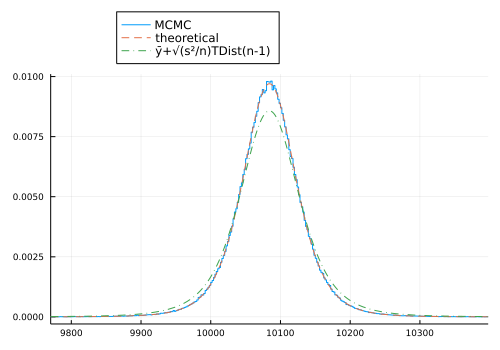

In [25]:
postμ_theoretical = posterior_μ_jeffreys(y)
postμ_ttest = posterior_μ_ttest(y)
plot(legend=:outertop)
stephist!(vec(chn[:μ]); norm=true, label="MCMC")
plot!(postμ_theoretical; label="theoretical", ls=:dash)
plot!(postμ_ttest; label="ȳ+√(s²/n)TDist(n-1)", ls=:dashdot)
plot!(xlim=quantile.(postμ_ttest, (0.001, 0.999)))

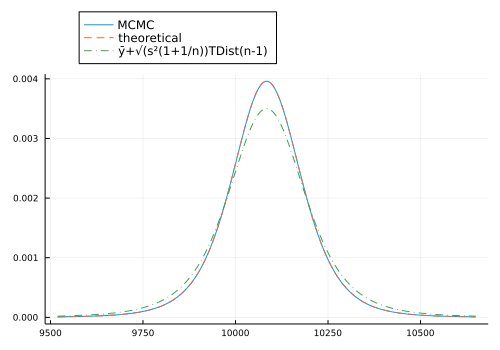

In [26]:
pdf_pred(y_new) = mean(pdf(Normal(μ, √σ²), y_new)
    for (μ, σ²) in zip(vec(chn[:μ]), vec(chn[:σ²])))
pred_theoretical = preddist_jeffreys(y)
pred_ttest = preddist_ttest(y)
xlim = quantile.(pred_theoretical, (0.001, 0.999))

plot(legend=:outertop)
plot!(pdf_pred, xlim...; label="MCMC")
plot!(pred_theoretical, xlim...; label="theoretical", ls=:dash)
plot!(pred_ttest, xlim...; label="ȳ+√(s²(1+1/n))TDist(n-1)", ls=:dashdot)

### 平均と対数分散について一様な事前分布の場合

平均 $\mu$ と分数の対数 $\log v = \log\sigma^2$ に関する一様な事前分布は

$$
p_\op{flat}(\mu, v) \propto v^{-1}
$$

になる. ただし, 右辺の $(\mu,v)\in\R\times\R_{>0}$ に関する積分は $\infty$ になるので, この事前分布はimproperである.

逆ガンマ正規分布の密度函数

$$
p_\op{InverseGammaNormal}(\mu,v|\mu_*, v_*, \kappa, \theta) \propto
v^{-(\kappa+1/2)-1}
\exp\left(-\frac{1}{v}\left(\theta + \frac{1}{2v_*}(\mu-\mu_*)^2\right)\right).
$$

と比較すると, 平均と対数分散について一様な事前分布に対応する共役事前分布のパラメータ値は形式的に次になることがわかる:

$$
\kappa \to -\frac{1}{2}, \quad
\theta \to 0, \quad
v_* \to \infty.
$$

このとき, Bayes更新後のパラメータの公式は次のようになる:

$$
\tilde\kappa = \frac{n-1}{2}, \quad
\tilde\theta = \frac{n\sigmahat^2}{2}, \quad
\tilde\mu_* = \ybar, \quad
\tilde v_* = \frac{1}{n}.
$$

この場合には

$$
\frac{\tilde\theta}{\tilde\kappa} = \frac{n\sigmahat^2}{n-1} = s^2, \quad
\tilde v_* = \frac{1}{n}, \quad
2\tilde\kappa = n-1.
$$

ここで, $s^2$ はデータの数値 $y_1,\ldots,y_n$ の不偏分散

$$
s^2 = \frac{1}{n-1}\sum_{i=1}^n(y_i - \ybar)^2 =
\frac{n\sigmahat^2}{n-1} > \sigmahat^2
$$

であり, $s$ はその平方根である.

ゆえに, $\mu$ に関する周辺事後分布は

$$
\mu \sim
\ybar + \frac{s}{\sqrt{n}}\;\op{TDist}(n-1)
$$

になり, $y_\op{new}$ に関する事後予測分布は次になる:

$$
y_\op{new} \sim
\ybar + s\sqrt{1+\frac{1}{n}}\;\op{TDist}(n-1).
$$

したがって, 前節の結果と比較すると, Jeffreys事前分布の事後分布と予測分布による区間推定よりもこの場合の区間推定は少し広くなる.

In [27]:
prior_flat() = 0.0, Inf, -1/2, 0.0

posterior_μ_flat(n, ȳ, s²) = ȳ + √(s²/n)*TDist(n-1)

function posterior_μ_flat(y)
    n, ȳ, s² = length(y), mean(y), var(y)
    posterior_μ_flat(n, ȳ, s²)
end

preddist_flat(n, ȳ, s²) = ȳ + √(s²*(1+1/n))*TDist(n-1)

function preddist_flat(y)
    n, ȳ, s² = length(y), mean(y), var(y)
    preddist_flat(n, ȳ, s²)
end

preddist_flat (generic function with 2 methods)

In [28]:
y = rand(Normal(10, 3), 5)
@show dist_true = Normal(μ_true, σ_true) n
n, ȳ, s² = length(y), mean(y), var(y)

dist_true = Normal(μ_true, σ_true) = Normal{Float64}(μ=10000.0, σ=100.0)
n = 5


(5, 12.39500386334508, 2.7250693784756224)

In [29]:
post_μ = posterior_μ(bayesian_update(prior_flat()..., y)...)

LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 12.39500386334508
σ: 0.7382505507584295
ρ: TDist{Float64}(ν=4.0)
)


In [30]:
posterior_μ_flat(y) ≈ post_μ

true

### 平均と対数分散について一様な事前分布の場合の結果の数値的確認

In [31]:
@model function normaldistmodel_flat(y)
    σ² ~ PowerPos(-1)
    μ ~ Flat()
    y ~ MvNormal(fill(μ, length(y)), σ²*I)
end

normaldistmodel_flat (generic function with 2 methods)

In [32]:
μ_true, σ_true, n = 1e4, 1e2, 5
@show dist_true = Normal(μ_true, σ_true) n
y = rand(Normal(μ_true, σ_true), n)

dist_true = Normal(μ_true, σ_true) = Normal{Float64}(μ=10000.0, σ=100.0)
n = 5


5-element Vector{Float64}:
 10024.894292237077
 10082.29826135682
  9883.033627479479
  9925.846275069784
  9857.238694168193

In [33]:
L = 10^5
n_threads = min(Threads.nthreads(), 10)
chn = sample(normaldistmodel_flat(y), NUTS(), MCMCThreads(), L, n_threads);

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.

┌ Info: Found initial step size
│   ϵ = 9.765625e-5
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 9.765625e-5
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 9.765625e-5
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 9.765625e-5
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 9.765625e-5
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @

In [34]:
chn

Chains MCMC chain (100000×14×10 Array{Float64, 3}):

Iterations        = 1001:1:101000
Number of chains  = 10
Samples per chain = 100000
Wall duration     = 20.62 seconds
Compute duration  = 165.49 seconds
parameters        = σ², μ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters         mean          std   naive_se      mcse           ess      ⋯
      Symbol      Float64      Float64    Float64   Float64       Float64   Fl ⋯

          σ²   18277.7351   37321.4636    37.3215   74.1366   234296.5066    1 ⋯
           μ    9954.6509      60.3105     0.0603    0.1153   277475.0743    1 ⋯
                                                               2 columns omitted

Quantiles
  parameters        2.5%       25.0%        50.0%        75.0%        97.5% 
      Symbol     Float64     Float64      Float64 

In [35]:
@show confint_ttest(y);

confint_ttest(y) = [9835.767050091436, 10073.557410033103]


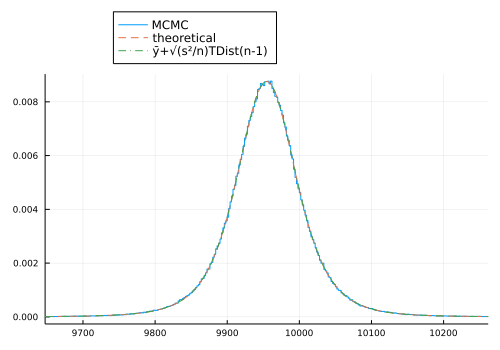

In [36]:
postμ_theoretical = posterior_μ_flat(y)
postμ_ttest = posterior_μ_ttest(y)
plot(legend=:outertop)
stephist!(vec(chn[:μ]); norm=true, label="MCMC")
plot!(postμ_theoretical; label="theoretical", ls=:dash)
plot!(postμ_ttest; label="ȳ+√(s²/n)TDist(n-1)", ls=:dashdot)
plot!(xlim=quantile.(postμ_ttest, (0.001, 0.999)))

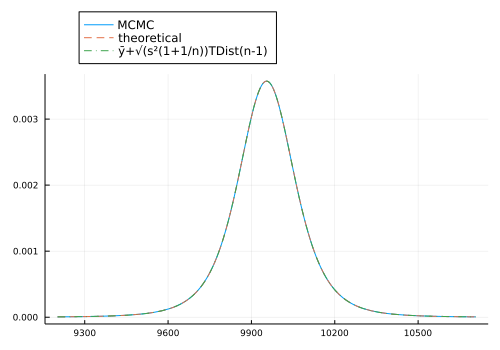

In [37]:
pdf_pred(y_new) = mean(pdf(Normal(μ, √σ²), y_new)
    for (μ, σ²) in zip(vec(chn[:μ]), vec(chn[:σ²])))
pred_theoretical = preddist_flat(y)
pred_ttest = preddist_ttest(y)
xlim = quantile.(pred_theoretical, (0.001, 0.999))

plot(legend=:outertop)
plot!(pdf_pred, xlim...; label="MCMC")
plot!(pred_theoretical, xlim...; label="theoretical", ls=:dash)
plot!(pred_ttest, xlim...; label="ȳ+√(s²(1+1/n))TDist(n-1)", ls=:dashdot)

### 通常の信頼区間と予測区間との比較

通常の $t$ 分布を使う平均の信頼区間と次の値の予測区間の構成では以下を使う:

$$
\frac{\ybar - \mu}{s\big/\!\sqrt{n}} \sim
\op{TDist}(n-1), \quad
\frac{y_\op{new} - \ybar}{s\sqrt{1+1/n}} \sim
\op{TDist}(n-1).
$$

ここで, $s^2$ はデータの数値の不偏分散であり, $s$ はその平方根である.

したがって, 前節の結果と比較すると, 通常の信頼区間と予測区間は, 平均と対数分散に関する一様事前分布に関する事後分布と予測分布を用いた区間推定に一致する.

### データの数値から事前分布を決めた場合

$a,b>0$ であると仮定する.

データの数値から共役事前分布のパラメータを次の条件によって決めたと仮定する:

$$
E[\mu] = \mu_* = \ybar, \quad
E[v] = \frac{\theta}{\kappa-1} = \sigmahat^2, \quad
\var(\mu) = v_* E[v] = a\sigmahat^2, \quad
\var(v) = \frac{E[v]^2}{\kappa-2} = b\sigmahat^4.
$$

これは次と同値である:

$$
\mu_* = \ybar, \quad
v_* = a, \quad
\kappa = 2 + \frac{1}{b}, \quad
\theta = \sigmahat^2\left(1 + \frac{1}{b}\right).
$$

このパラメータ値に対応する共役事前分布を以下では __適応事前分布__ (adaptive prior)と呼ぶことにする(注意: ここだけの用語).

これのBayes更新の結果は以下のようになる:

$$
\begin{alignedat}{2}
&
\tilde\kappa = 2 + \frac{1}{b} + \frac{n}{2} =
\frac{n}{2}\left(1 + \frac{2(2+1/b)}{n}\right)
& &
\to 2 + \frac{n}{2},
\\ &
\tilde\theta =
\sigmahat^2\left(1 + \frac{1}{b} + \frac{n}{2}\right) + \frac{n}{2}\frac{(\ybar - \ybar)^2}{1+na} =
\frac{n\sigmahat^2}{2}\left(1 + \frac{2(1+1/b))}{n}\right)
& &
\to \sigmahat^2\left(1 + \frac{n}{2}\right),
\\ &
\tilde\mu_* = \frac{\ybar+nv_*\ybar}{1+nv_*} =
\ybar
& &
\to \ybar,
\\ &
\tilde v_* = \frac{a}{1+na} =
\frac{1}{n}\frac{1}{1+1/(na)}
& &
\to \frac{1}{n}.
\end{alignedat}
$$

以上における $\to$ は $a\to\infty$, $b\to\infty$ での極限を意味する.

適応事前分布の構成のポイントは, $\mu_* = \ybar$ となっているおかげで, $\tilde\mu_*$ も $\tilde\mu_* = \ybar$ となってバイアスが消え, さらに, $\tilde\theta$ の中の $\ds\frac{n}{2}\frac{(\ybar - \mu_*)^2}{1+na}$ の項が消えて, 区間推定の幅が無用に広くならずに済むことである.

ただし, 適応事前分布の場合には 

$$
\frac{\tilde\theta}{\tilde\kappa} =
\sigmahat^2\frac{1 + 2(1+1/b)/n}{1 + 2(2+1/b)/n} < \sigmahat^2, \quad
v_* = \frac{1}{n}\frac{1}{1+1/(na)} < \frac{1}{n}
$$

なので, 区間推定の幅はJeffreys事前分布の場合よりも少し狭くなる.

しかし, $n$ が大きければそれらの違いは小さくなる.

In [38]:
function prior_adaptive(n, ȳ, σ̂²; a = 2.5, b = 2.5)
    μstar = ȳ
    vstar = a
    κ = 2 + 1/b
    θ = σ̂²*(1 + 1/b)
    μstar, vstar, κ, θ
end

function prior_adaptive(y; a = 2.5, b = 2.5)
    n, ȳ, σ̂² = length(y), mean(y), var(y; corrected=false)
    prior_adaptive(n, ȳ, σ̂²; a, b)
end

function posterior_adaptive(n, ȳ, σ̂²; a = 2.5, b = 2.5)
    μstar = ȳ
    vstar = 1/(1/a + n)
    κ = 2 + 1/b + n/2
    θ = σ̂²*(1 + 1/b + n/2)
    μstar, vstar, κ, θ
end

function posterior_adaptive(y; a = 2.5, b = 2.5)
    n, ȳ, σ̂² = length(y), mean(y), var(y; corrected=false)
    posterior_adaptive(n, ȳ, σ̂²; a, b)
end

posterior_adaptive (generic function with 2 methods)

In [39]:
μ_true, σ_true, n = 1e4, 1e2, 5
@show dist_true = Normal(μ_true, σ_true) n
y = rand(Normal(μ_true, σ_true), n)

dist_true = Normal(μ_true, σ_true) = Normal{Float64}(μ=10000.0, σ=100.0)
n = 5


5-element Vector{Float64}:
 10102.081118449192
  9930.482431353284
 10080.615815000865
 10015.69095813968
 10014.573059324306

In [40]:
n, ȳ, σ̂² = length(y), mean(y), var(y; corrected=false)

(5, 10028.688676453467, 3619.1072329590634)

In [41]:
μstar, vstar, κ, θ = prior_adaptive(y)
a, b = 2.5, 2.5
@show ȳ, σ̂², a*σ̂², b*σ̂²^2
(ȳ, σ̂², a*σ̂², b*σ̂²^2) .≈ (μstar, θ/(κ - 1), (θ/(κ - 1))*vstar, (θ/(κ - 1))^2/(κ - 2))

(ȳ, σ̂², a * σ̂², b * σ̂² ^ 2) = (10028.688676453467, 3619.1072329590634, 9047.768082397659, 3.274484290914152e7)


(true, true, true, true)

In [42]:
posterior_adaptive(n, ȳ, σ̂²)

(10028.688676453467, 0.18518518518518517, 4.9, 14114.518208540347)

In [43]:
bayesian_update(prior_adaptive(y)..., y)

(10028.688676453465, 0.18518518518518517, 4.9, 14114.518208540347)

In [44]:
posterior_adaptive(y)

(10028.688676453467, 0.18518518518518517, 4.9, 14114.518208540347)

In [45]:
posterior_adaptive(y) .≈ bayesian_update(prior_adaptive(y)..., y)

(true, true, true, true)

### n = 5 では適応事前分布の場合と無情報事前分布の場合の結果が結構違う.

In [46]:
@model function normaldistmodel_adaptive(y; a = 2.5, b = 2.5)
    μstar, vstar, κ, θ = prior_adaptive(y; a, b)
    σ² ~ InverseGamma(κ, θ)
    μ ~ Normal(μstar, √(vstar * σ²))
    y ~ MvNormal(fill(μ, length(y)), σ²*I)
end

normaldistmodel_adaptive (generic function with 2 methods)

In [47]:
μ_true, σ_true, n = 1e4, 1e2, 5
@show dist_true = Normal(μ_true, σ_true) n
y = rand(Normal(μ_true, σ_true), n)

dist_true = Normal(μ_true, σ_true) = Normal{Float64}(μ=10000.0, σ=100.0)
n = 5


5-element Vector{Float64}:
  9946.069559502377
  9861.83165688509
  9901.766727197712
 10041.100428003567
 10031.689212218684

In [48]:
L = 10^5
n_threads = min(Threads.nthreads(), 10)
chn = sample(normaldistmodel_adaptive(y), NUTS(), MCMCThreads(), L, n_threads);

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.

In [49]:
chn

Chains MCMC chain (100000×14×10 Array{Float64, 3}):

Iterations        = 1001:1:101000
Number of chains  = 10
Samples per chain = 100000
Wall duration     = 16.8 seconds
Compute duration  = 157.85 seconds
parameters        = σ², μ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters        mean         std   naive_se      mcse           ess      r ⋯
      Symbol     Float64     Float64    Float64   Float64       Float64   Floa ⋯

          σ²   4978.4667   2954.9242     2.9549    4.3254   465317.3372    1.0 ⋯
           μ   9956.4990     30.4058     0.0304    0.0394   590162.5211    1.0 ⋯
                                                               2 columns omitted

Quantiles
  parameters        2.5%       25.0%       50.0%       75.0%        97.5% 
      Symbol     Float64     Float64     Float64     

In [50]:
@show confint_ttest(y);

confint_ttest(y) = [9858.570603726548, 10054.412429796423]


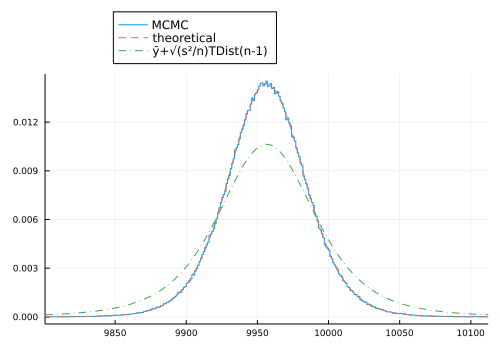

In [51]:
postμ_theoretical = posterior_μ(posterior_adaptive(y)...)
postμ_ttest = posterior_μ_ttest(y)
plot(legend=:outertop)
stephist!(vec(chn[:μ]); norm=true, label="MCMC")
plot!(postμ_theoretical; label="theoretical", ls=:dash)
plot!(postμ_ttest; label="ȳ+√(s²/n)TDist(n-1)", ls=:dashdot)
plot!(xlim=quantile.(postμ_theoretical, (0.0001, 0.9999)))

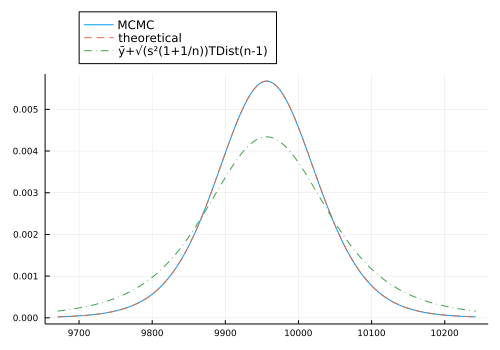

In [52]:
pdf_pred(y_new) = mean(pdf(Normal(μ, √σ²), y_new)
    for (μ, σ²) in zip(vec(chn[:μ]), vec(chn[:σ²])))
pred_theoretical = preddist(posterior_adaptive(y)...)
pred_ttest = preddist_ttest(y)
xlim = quantile.(pred_theoretical, (0.001, 0.999))

plot(legend=:outertop)
plot!(pdf_pred, xlim...; label="MCMC")
plot!(pred_theoretical, xlim...; label="theoretical", ls=:dash)
plot!(pred_ttest, xlim...; label="ȳ+√(s²(1+1/n))TDist(n-1)", ls=:dashdot)

以上のように $n=5$ の場合には, 適応事前分布の場合の結果は無情報事前分布の場合の結果(緑のdashdotライン)とかなり違う.

### n = 20 ではデフォルト事前分布の場合と無情報事前分布の場合の結果が近付く.

In [53]:
μ_true, σ_true, n = 1e4, 1e2, 20
@show dist_true = Normal(μ_true, σ_true) n
y = rand(dist_true, n);

dist_true = Normal(μ_true, σ_true) = Normal{Float64}(μ=10000.0, σ=100.0)
n = 20


In [54]:
L = 10^5
n_threads = min(Threads.nthreads(), 10)
chn = sample(normaldistmodel_adaptive(y), NUTS(), MCMCThreads(), L, n_threads);

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
Sampling (10 threads): 100%|████████████████████████████| Time: 0:00:03


In [55]:
chn

Chains MCMC chain (100000×14×10 Array{Float64, 3}):

Iterations        = 1001:1:101000
Number of chains  = 10
Samples per chain = 100000
Wall duration     = 14.84 seconds
Compute duration  = 143.37 seconds
parameters        = σ², μ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters         mean         std   naive_se      mcse           ess       ⋯
      Symbol      Float64     Float64    Float64   Float64       Float64   Flo ⋯

          σ²   12368.7834   3839.5999     3.8396    4.6957   739574.7499    1. ⋯
           μ    9975.2061     24.6510     0.0247    0.0265   850524.2570    1. ⋯
                                                               2 columns omitted

Quantiles
  parameters        2.5%       25.0%        50.0%        75.0%        97.5% 
      Symbol     Float64     Float64      Float64 

In [56]:
@show confint_ttest(y);

confint_ttest(y) = [9921.786329083172, 10028.567649950483]


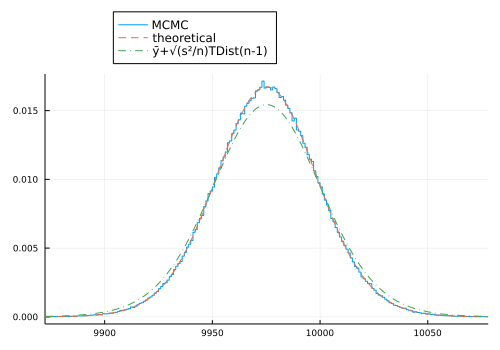

In [57]:
postμ_theoretical = posterior_μ(posterior_adaptive(y)...)
postμ_ttest = posterior_μ_ttest(y)
plot(legend=:outertop)
stephist!(vec(chn[:μ]); norm=true, label="MCMC")
plot!(postμ_theoretical; label="theoretical", ls=:dash)
plot!(postμ_ttest; label="ȳ+√(s²/n)TDist(n-1)", ls=:dashdot)
plot!(xlim=quantile.(postμ_theoretical, (0.0001, 0.9999)))

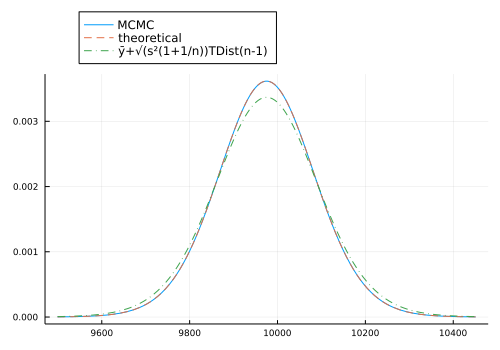

In [58]:
pdf_pred(y_new) = mean(pdf(Normal(μ, √σ²), y_new)
    for (μ, σ²) in zip(vec(chn[:μ]), vec(chn[:σ²])))
pred_theoretical = preddist(posterior_adaptive(y)...)
pred_ttest = preddist_ttest(y)
xlim = quantile.(pred_theoretical, (0.0001, 0.9999))

plot(legend=:outertop)
plot!(pdf_pred, xlim...; label="MCMC")
plot!(pred_theoretical, xlim...; label="theoretical", ls=:dash)
plot!(pred_ttest, xlim...; label="ȳ+√(s²(1+1/n))TDist(n-1)", ls=:dashdot)

### n = 20 で事前分布とデータの数値の相性が悪い場合

In [59]:
@model function normaldistmodel(y, μstar, vstar, κ, θ)
    σ² ~ InverseGamma(κ, θ)
    μ ~ Normal(μstar, √(vstar * σ²))
    y ~ MvNormal(fill(μ, length(y)), σ²*I)
end

normaldistmodel (generic function with 2 methods)

In [60]:
a, b = 10.0, 10.0
μstar, vstar, κ, θ = 0.0, a, 2 + 1/b, 1 + 1/b
@show μstar vstar κ θ
println()

Eμ, Ev = μstar, θ/(κ - 1)
var_μ, var_v = vstar*Ev, Ev^2/(κ - 2)
@show Eμ Ev var_μ var_v;

μstar = 0.0
vstar = 10.0
κ = 2.1
θ = 1.1

Eμ = 0.0
Ev = 1.0
var_μ = 10.0
var_v = 9.999999999999991


In [61]:
μ_true, σ_true, n = 1e4, 1e2, 20
@show dist_true = Normal(μ_true, σ_true) n
y = rand(dist_true, n);

dist_true = Normal(μ_true, σ_true) = Normal{Float64}(μ=10000.0, σ=100.0)
n = 20


In [62]:
L = 10^5
n_threads = min(Threads.nthreads(), 10)
chn = sample(normaldistmodel(y, μstar, vstar, κ, θ), NUTS(), MCMCThreads(), L, n_threads);

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.

In [63]:
chn

Chains MCMC chain (100000×14×10 Array{Float64, 3}):

Iterations        = 1001:1:101000
Number of chains  = 10
Samples per chain = 100000
Wall duration     = 17.33 seconds
Compute duration  = 165.4 seconds
parameters        = σ², μ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters          mean           std   naive_se       mcse           ess   ⋯
      Symbol       Float64       Float64    Float64    Float64       Float64   ⋯

          σ²   460313.9575   144591.6418   144.5916   175.2699   747641.9204   ⋯
           μ     9944.9300      151.5219     0.1515     0.1699   840324.4052   ⋯
                                                               2 columns omitted

Quantiles
  parameters          2.5%         25.0%         50.0%         75.0%         9 ⋯
      Symbol       Float64       Float64       

In [64]:
@show confint_ttest(y);

confint_ttest(y) = [9937.96631203703, 10051.285553453114]


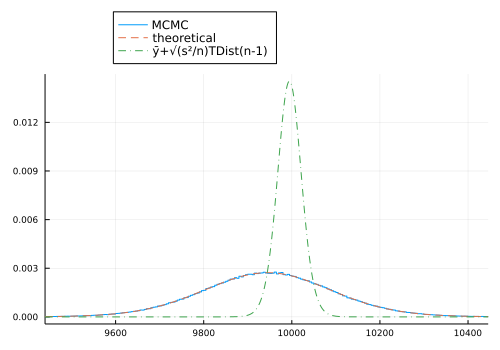

In [65]:
postμ_theoretical = posterior_μ(bayesian_update(μstar, vstar, κ, θ, y)...)
postμ_ttest = posterior_μ_ttest(y)
xlim = quantile.(Ref(vec(chn[:μ])), (0.001, 0.999))

plot(legend=:outertop)
stephist!(vec(chn[:μ]); norm=true, label="MCMC")
plot!(postμ_theoretical, xlim...; label="theoretical", ls=:dash)
plot!(postμ_ttest, xlim...; label="ȳ+√(s²/n)TDist(n-1)", ls=:dashdot)
plot!(; xlim)

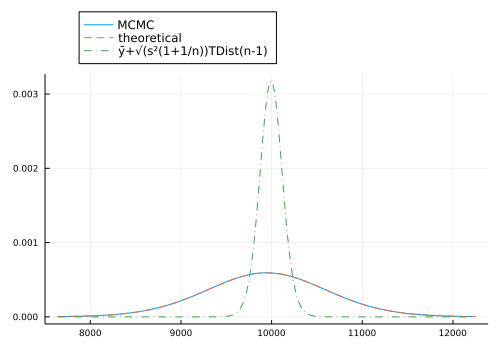

In [66]:
pdf_pred(y_new) = mean(pdf(Normal(μ, √σ²), y_new)
    for (μ, σ²) in zip(vec(chn[:μ]), vec(chn[:σ²])))
pred_theoretical = preddist(bayesian_update(μstar, vstar, κ, θ, y)...)
pred_ttest = preddist_ttest(y)
xlim = quantile.(pred_theoretical, (0.001, 0.999))

plot(legend=:outertop)
plot!(pdf_pred, xlim...; label="MCMC")
plot!(pred_theoretical, xlim...; label="theoretical", ls=:dash)
plot!(pred_ttest, xlim...; label="ȳ+√(s²(1+1/n))TDist(n-1)", ls=:dashdot)